In [1]:
import numpy as np
import pandas as pd
import progressbar as pb
import time
import warnings
import text_processing as tp
warnings.filterwarnings('ignore')
import pickle

In [2]:
# Import dataset
data = pd.read_csv('TestData2500.csv',sep=',')
# Remove nan from the main dataset
tp.remove_nan(data)

Remove NA
Before removing the NaN:
id                 0
product            0
component          0
reporter           0
bug_status         0
resolution         0
priority           0
bug_severity       0
version            0
short_desc         1
opendate           0
dup_list        1499
root_id         1406
disc_id         1406
dtype: int64

After removing the NaN:
 id                 0
product            0
component          0
reporter           0
bug_status         0
resolution         0
priority           0
bug_severity       0
version            0
short_desc         0
opendate           0
dup_list        1498
root_id         1405
disc_id         1405
dtype: int64


In [3]:
# Preprocessing the short_desc
processed_data_df = tp.text_preprocessing(data,"short_desc")
# Save to file to save time
processed_data_df.to_csv('processed_TestData2500_df.csv',index=False)

  0% (3 of 1594) |                       | Elapsed Time: 0:00:00 ETA:   0:01:07

Preprocessing the text


 99% (1592 of 1594) |################### | Elapsed Time: 0:01:04 ETA:   0:00:00

Remove NA
Before removing the NaN:
id                         0
short_desc_processed       0
product                    0
component                  0
reporter                   0
bug_status                 0
resolution                 0
priority                   0
bug_severity               0
version                    0
short_desc                 0
opendate                   0
dup_list                1498
root_id                 1405
disc_id                 1405
dtype: int64

After removing the NaN:
 id                         0
short_desc_processed       0
product                    0
component                  0
reporter                   0
bug_status                 0
resolution                 0
priority                   0
bug_severity               0
version                    0
short_desc                 0
opendate                   0
dup_list                1498
root_id                 1405
disc_id                 1405
dtype: int64
Text preprocessing --- 64.16023778915405 se

In [ ]:
# Load prosecced df from file to sasve time
processed_data_df = pd.read_csv('processed_TestData2500_df.csv',sep=',')

In [4]:
# Model-1: Similarity Score - Word2vec -------------------------------------------------------------------------
import spacy
nlp = spacy.load('en_core_web_lg')
execution_count_word2vec = 0
processed_data_nlp_df = []

# Convert short_desc str to nlp format to fasten the computation process 
def word2vec_preprocess(df):
    print('Convert short_desc str to nlp format')
    sample_size = len(df)
    progress = pb.ProgressBar(maxval = sample_size).start()
    progvar  = 0
    processed_data_nlp = []
    for tup in df.itertuples():
        processed_data_nlp.append((tup.id,tup.product,nlp(tup.short_desc_processed))) 
        progress.update(progvar + 1)
        progvar += 1
    global processed_data_nlp_df
    processed_data_nlp_df = pd.DataFrame(processed_data_nlp, columns=['id','product','short_desc_processed'])
    global execution_count_word2vec
    execution_count_word2vec += 1

# Calculate the cosine similarity score
def word2vec_similarity(id,df):
    if execution_count_word2vec == 0:
        word2vec_preprocess(df)
    similarities_score_list = []
    product_main = processed_data_nlp_df.loc[lambda df: df['id'] == id,'product'].array[0]
    short_desc_processed_main = processed_data_nlp_df.loc[lambda df: df['id'] == id,'short_desc_processed'].array[0]
    for doc in processed_data_nlp_df.itertuples():
        product_other = processed_data_nlp_df.loc[lambda df: df['id'] == doc.id,'product'].array[0]
        if product_main == product_other:
            similarity_score = doc.short_desc_processed.similarity(short_desc_processed_main)
            similarities_score_list.append((doc.id,similarity_score))
    #convert to dataframe
    word2vec_similarities_score_df = pd.DataFrame(similarities_score_list, columns=['id','word2vec_score'] )
    word2vec_similarities_score_df = word2vec_similarities_score_df.reset_index(drop=True)
    return word2vec_similarities_score_df

In [5]:
# Model-2: Similarity Score - TF-idf ----------------------------------------------------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

tfidf_cosine_similarities = []
execution_count_tfidf = 0

def tfidf_preprocess(df):
    X_train = df['short_desc_processed']
    print('TF-idf Vectorization and similarity score computation')
    # Vectorization
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform(X_train)
    # Calculate the cosine similarity score
    global tfidf_cosine_similarities
    tfidf_cosine_similarities = linear_kernel(tfidf)
    global shape_tfidf
    shape_tfidf = tfidf_cosine_similarities.shape[0]
    print('TF-idf preprocess done')
    global execution_count_tfidf
    execution_count_tfidf += 1

def tfidf_similarities(id,df):
    if execution_count_tfidf == 0:
        tfidf_preprocess(df)
    index_main   = df.loc[lambda df: df['id'] == id].index.array[0]
    product_main = df.loc[lambda df: df['id'] == id,'product'].array[0]
    tfidf_cosine_similarities_list = []
    for index_other in range(shape_tfidf):
        id_other      = df.iloc[index_other]['id']
        product_other = df.iloc[index_other]['product']
        if product_main == product_other:
            tfidf_cosine_similarities_list.append([id_other,tfidf_cosine_similarities[index_main,index_other]])
    #Conver to dataframe
    tfidf_cosine_similarities_score_df = pd.DataFrame(tfidf_cosine_similarities_list, columns=['id','tfidf_score'])
    tfidf_cosine_similarities_score_df = tfidf_cosine_similarities_score_df.reset_index(drop=True)
    return tfidf_cosine_similarities_score_df

In [6]:
# Model-3: Similarity Score - BM24F -----------------------------------------------------------------------------
from rank_bm25 import BM25Okapi

processed_corpus_list = []
bm25 = []
execution_count_bm25 = 0

# preprocess - tokenize the short_desc to token
def bm24_preprocess(df):
    print('preprocess - tokenize the short_desc to token')
    sample_size = len(df)
    global processed_corpus_list
    processed_corpus_list = []
    for x in df.itertuples():
        short_desc_splited = x.short_desc_processed.split(" ")
        processed_corpus_list.append(short_desc_splited)
    # Create a MB24 Object with the corpus
    global bm25
    bm25 = BM25Okapi(processed_corpus_list)
    global execution_count_bm25
    execution_count_bm25 += 1
    
# Calculate the similarity score
def bm24_similarity(id,df):
    if execution_count_bm25 == 0:
        bm24_preprocess(df)
    index_main    = df.loc[lambda df: df['id'] == id].index.array[0]
    product_main  = df.loc[lambda df: df['id'] == id,'product'].array[0]
    query         = processed_corpus_list[index_main]
    doc_scores    = bm25.get_scores(query)
    doc_scores_df = pd.DataFrame(doc_scores, columns=['bm24_score'])
    # add id to the score list and remove unsimiliar product
    blanks = []
    for x in doc_scores_df.itertuples():
        id_other      = df.iloc[x.Index]['id']
        product_other = df.iloc[x.Index]['product']
        # add id to the score list
        doc_scores_df.loc[x.Index,'id'] = id_other
        if product_main != product_other:
            blanks.append(x.Index)    
    doc_scores_df.drop(blanks,inplace=True)   
    doc_scores_df = doc_scores_df.reset_index(drop = True)  
    return doc_scores_df

Assessment the Model Accuracy

In [7]:
# Assessment the Model Accuracy -------------------------------------------------------------------------------
# duplicate_df = pd.read_csv('https://zenodo.org/record/400614/files/apache.relations.csv?download=1',sep=',')
duplicate_df = pd.read_csv('duplicate_df.csv',sep=',')

In [8]:
# Calculate the similarity scores and return the first n top scoes
def similarity_score(id, df,top_n):
    word2vec_similarity_df = word2vec_similarity(id, df).sort_values(by=['word2vec_score'],ascending=False).head(top_n)
    tfidf_similarity_df    = tfidf_similarities(id, df).sort_values(by=['tfidf_score'],ascending=False).head(top_n)
    bm24_similarity_df     = bm24_similarity(id, df).sort_values(by=['bm24_score'],ascending=False).head(top_n)    
    return word2vec_similarity_df, tfidf_similarity_df, bm24_similarity_df

In [26]:
# Calculate the similarity score for the reported duplicated bug report
start_time  = time.time()
sample_size = len(duplicate_df)
progress    = pb.ProgressBar(maxval = sample_size).start()
progvar     = 0
duplicated_similarity_score_list = []

for tup in duplicate_df.itertuples():
    word2vec_similarity_df, tfidf_similarity_df, bm24_similarity_df = similarity_score(tup.id, processed_data_df,10)
    duplicated_similarity_score_list.append([tup.id,tup.dup,word2vec_similarity_df,tfidf_similarity_df,bm24_similarity_df])
    progress.update(progvar + 1)
    progvar += 1
    
print("-Total- %s seconds ---" % (time.time() - start_time))

100% (83 of 83) |########################| Elapsed Time: 0:03:00 ETA:  00:00:00

-Total- 180.82528567314148 seconds ---


In [27]:
# Save the list to a file since it takes 8 hours to create it
# with open("duplicated_similarity_score_list_2500.txt", "wb") as fp:   #Pickling
#     pickle.dump(duplicated_similarity_score_list, fp)

# # Read the list from a file 
# with open("duplicated_similarity_score_list_2500.txt", "rb") as fp:   # Unpickling
#     duplicated_similarity_score_list = pickle.load(fp)

In [28]:
# Calculate the Recall rate
def recall_rate_calculation(name_of_algorthem):
    if name_of_algorthem == 'word2vec':
        select_algorithm = 2
        print('word2vec result:')
    elif name_of_algorthem == 'tfidf':
        select_algorithm = 3
        print('TF-idf result:')
    elif name_of_algorthem == 'bm24':
        select_algorithm = 4
        print('bm24 result:')
    else:
        return "Wrong selection"
    found_counter = 0
    not_found_counter = 0
    for x in duplicated_similarity_score_list:
        dup = x[1]
        df = x[select_algorithm]
        if df.loc[df['id'] == dup].empty:
            not_found_counter +=1
        else:
            found_counter +=1
    print('Num of duplicated report found: ',found_counter)
    print('Num of duplicated report not found: ',not_found_counter)
    print('Recall (TP/TP+FN): ', round(found_counter/len(duplicated_similarity_score_list)*100,2),'%\n')

In [29]:
# Check the results
recall_rate_calculation('word2vec')
recall_rate_calculation('tfidf')
recall_rate_calculation('bm24')

word2vec result:
Num of duplicated report found:  37
Num of duplicated report not found:  46
Recall (TP/TP+FN):  44.58 %

TF-idf result:
Num of duplicated report found:  42
Num of duplicated report not found:  41
Recall (TP/TP+FN):  50.6 %

bm24 result:
Num of duplicated report found:  41
Num of duplicated report not found:  42
Recall (TP/TP+FN):  49.4 %



Calculate the MRR 
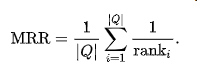

In [ ]:
# Calculate the MRR
def MRR_rate_calculation(name_of_algorthem):
    if name_of_algorthem == 'word2vec':
        select_algorithm = 2
        print('word2vec result:')
    elif name_of_algorthem == 'tfidf':
        select_algorithm = 3
        print('TF-idf result:')
    elif name_of_algorthem == 'bm24':
        select_algorithm = 4
        print('bm24 result:')
    else:
        return "Wrong selection"
    found_counter = 0
    not_found_counter = 0
    for x in duplicated_similarity_score_list:
        dup = x[1]
        df = x[select_algorithm]
        if df.loc[df['id'] == dup].empty:
            not_found_counter +=1
        else:
            
            found_counter +=1
    print('Num of duplicated report found: ',found_counter)
    print('Num of duplicated report not found: ',not_found_counter)
    print('Recall (TP/TP+FN): ', round(found_counter/len(duplicated_similarity_score_list)*100,2),'%\n')

In [31]:
duplicated_similarity_score_list[1][2]

,id,word2vec_score
64,144,1.000000
65,145,0.959616
243,367,0.818042
543,1705,0.791714
69,149,0.790835
44,122,0.789630
332,521,0.782684
560,1807,0.780917
640,2396,0.780185
431,1012,0.776989
